<a href="https://colab.research.google.com/github/datasciencechampion/Zero-to-Hero-in-NLP-LLM-GenAI-AGI/blob/main/RAG/QuestionAnsweringSystem_using_Mistral7B_on_pdf_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing Semantic Search & Question Answering System - for pdf document**

This module is part of [Zero-to-Hero in data Science](https://colab.research.google.com/drive/1EGLE0Lnst0CNmkw5BOFGSqIT5oxl5xYW?usp=sharing)

Author : [Pramod Singh](https://www.linkedin.com/in/pramod-singh-4635962/)

# Topic Covered
- [Implementing Question Answering System for pdf document](#1)
  - [Installing libraries](#1.1)
  - [Setting storage](#1.2)
  - [Importing Required Libraries](#1.3)
  - [Loading pdf document](#1.4)
  - [Chunking pdf document](#1.5)
  - [Embedding chunks and storing in Vector database(Chroma db)](#1.6)
  - [Verifying if semantic search is returning correct chunk](#1.7)
  - [Generating final answer using GenAI model from Mistral](#1.8)

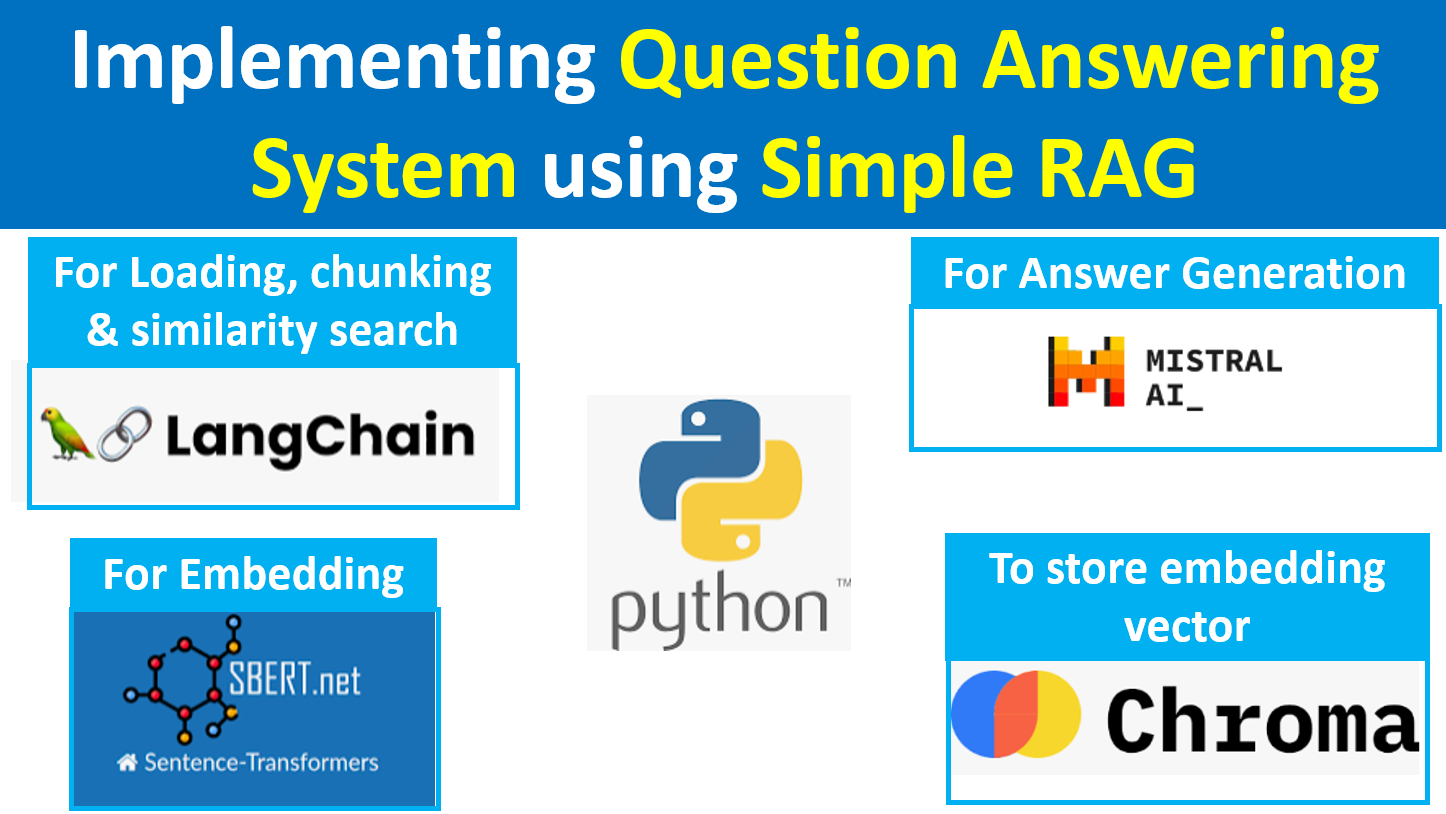

<a name='1'></a>
# **Implementing Question Answering System for pdf document**


<a name='1.1'></a>
# Installing libraries

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U einops
!pip install -q -U safetensors
!pip install -q -U torch
!pip install -q -U xformers
!pip install -q -U langchain
!pip install -q -U ctransformers[cuda]
!pip install chromadb
!pip install sentence-transformers
!pip install pypdf
!pip install sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

<a name='1.2'></a>
## Setting storage

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


<a name='1.3'></a>
## Importing required Libraries

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.vectorstores import Chroma
import os
import torch
from transformers import BitsAndBytesConfig
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline


<a name='1.4'></a>
## Loading pdf document

In [ ]:
pdf_file_path="/content/gdrive/MyDrive/SampleData/transformer_paper.pdf"
embedding_persistant_directory="/content/gdrive/MyDrive/SampleData/Embedding_vector"

In [ ]:
#PyPDFLoader loads PDF using pypdf into array of documents, where each document contains the page content and metadata with page number.
loader = PyPDFLoader(pdf_file_path)
pages = loader.load()

In [ ]:
len(pages)

15

In [ ]:
pages[2]

Document(page_content='Figure 1: The Transformer - model architecture.\nThe Transformer follows this overall architecture using stacked self-attention and point-wise, fully\nconnected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,\nrespectively.\n3.1 Encoder and Decoder Stacks\nEncoder: The encoder is composed of a stack of N= 6 identical layers. Each layer has two\nsub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-\nwise fully connected feed-forward network. We employ a residual connection [ 11] around each of\nthe two sub-layers, followed by layer normalization [ 1]. That is, the output of each sub-layer is\nLayerNorm( x+ Sublayer( x)), where Sublayer( x)is the function implemented by the sub-layer\nitself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding\nlayers, produce outputs of dimension dmodel = 512 .\nDecoder: The decoder is also composed 

<a name='1.5'></a>
## Chunking pdf document

We are using LangChain's **RecursiveCharacterTextSplitter**

Here,

Text is split by list of characters. The default list is ["\n\n", "\n", " ", ""].

Chunk size is measured by number of characters.



In [ ]:
# split documents
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
chunks = text_splitter.split_documents(pages)

In [ ]:
len(chunks)

49

In [ ]:
chunks[0].page_content

'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.comNoam Shazeer∗\nGoogle Brain\nnoam@google.comNiki Parmar∗\nGoogle Research\nnikip@google.comJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.comAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and con

<a name='1.6'></a>
## Embedding chunks and storing in Vector database(Chroma db)

For embedding we are going to use open-source models

🎯 **all-MiniLM-L6-v2**

Huggingface : https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search. SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. The initial work is described in this paper Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks.

## Intended uses

This model is intented to be used as a sentence and short paragraph encoder. Given an input text, it ouptuts a vector which captures the semantic information. The sentence vector may be used for information retrieval, clustering or sentence similarity tasks.

By default, input text longer than 256 word pieces is truncated.

🎯 **all-mpnet-base-v2**

This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.

### Intended uses

This model is intented to be used as a sentence and short paragraph encoder. Given an input text, it ouptuts a vector which captures the semantic information. The sentence vector may be used for information retrieval, clustering or sentence similarity tasks.

By default, input text longer than 384 word pieces is truncated.

In [ ]:
# Loading open-source embedding model
#embedding = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
embedding = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Embedding text chunk into Chroma db & Searching

We are using **Chroma DB** through **LangChain library**.

The **Chroma.from_documents** method creates a new Chroma instance and populates its vector store with the provided documents. It does this by extracting and iterating through the text and optional metadata from each document and embedding them and adding them to the vector store.

In [ ]:
db = Chroma.from_documents(documents=chunks, embedding=embedding, persist_directory=embedding_persistant_directory)

In [ ]:
query = "what is transformer?"

### How similarity_search() works

The embedding model, specified during the creation of the Chroma database (db), is already integrated within the similarity_search function.
When we provide the **query** string to **similarity_search**, it first passes the query through the embedding model to generate query embedding.

The generated query embedding is then compared to the embeddings of all the text chunks stored in the Chroma database.

The similarity scores are calculated using **cosine similarity** that measures the degree of alignment between the vectors.

The chunks with the highest similarity scores, are retrieved and returned as the results of the search.

The argument **k** specifies the number of top or similar chunk should be retrieved. If **k=1** then the top most ( best matched chunk) will be returned.

In [ ]:
chunks_with_query_context = db.similarity_search(query,k=1)

In [ ]:
# Print the results
print("Search Results:")
for i, result in enumerate(chunks_with_query_context, 1):
    print(f"Result {i}:\n {result}\n")

Search Results:
Result 1:
 page_content='Figure 1: The Transformer - model architecture.\nThe Transformer follows this overall architecture using stacked self-attention and point-wise, fully\nconnected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,\nrespectively.\n3.1 Encoder and Decoder Stacks\nEncoder: The encoder is composed of a stack of N= 6 identical layers. Each layer has two\nsub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-\nwise fully connected feed-forward network. We employ a residual connection [ 11] around each of\nthe two sub-layers, followed by layer normalization [ 1]. That is, the output of each sub-layer is\nLayerNorm( x+ Sublayer( x)), where Sublayer( x)is the function implemented by the sub-layer\nitself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding\nlayers, produce outputs of dimension dmodel = 512 .' metadata={'page': 2,

# Helper Functions

## search_chromadb(db,question,k)

This function takes the vector database of the entire chunk, user query and top matching chunks. Then performs the similarity search using cosine-similarity and returns the top match chunk.

Input parameters :

⭐ db : database instance of embedding vector

⭐ question : user question for semantic search

⭐ k : counts for how many chunks from best match to return in decending order of cosine similarity score.

This function returns top k best matched chunks

In [ ]:
def search_chromadb(db, question, k):
    try:
        if not db:
            raise ValueError("Database object is not provided.")

        if not question or not isinstance(question, str):
            raise ValueError("Invalid question input.")

        if not isinstance(k, int) or k < 1:
            raise ValueError("Invalid value for 'k'. 'k' should be an integer greater than or equal to 1.")

        docs = db.similarity_search(question, k=k)

        if not docs:
            print(f"No documents found in the database for the query: {question}")
            return []

        results = [doc.page_content for doc in docs if doc.page_content]

        if not results:
            print("No non-empty results from semantic search.")

        print(f"\nChunks from semantic search: {results}")
        return results

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        # You can log the error or handle it in an appropriate way based on your needs.
        return []


##generate_answer(question, context)

This function takes the user query and top matched chunk (context) and generates the final answer using OpenAI model gpt-3.5-turbo.


Input parameters :

⭐ question : user question

⭐ context : chunks returned by search_chromadb() for question.


This function internally calles OpenAI API **client.chat.completions.create** which takes following parameters:

Parameters for generative model GPT-3.5-turbo :

⭐ model="gpt-3.5-turbo": This specifies the language model to be used for the completion. GPT-3.5-turbo is a large language model known for its advanced capabilities in text generation and understanding.

⭐messages=[ ... ]: *This* provides a list of messages that form the context for the completion. It includes:
A system message prompting the model to answer the question based on the context.
A user message containing the actual context and question to be answered.
temperature=1: This controls the creativity and randomness of the generated text. A higher temperature leads to more creative and unexpected responses, while a lower temperature produces more conservative and predictable text.

⭐ max_tokens=500: This sets a limit on the maximum number of tokens (words or subwords) in the generated response.

⭐ top_p=1: This parameter influences the level of diversity and safety in the generated text. A value of 1 encourages the model to explore a wider range of possibilities, while lower values prioritize more likely and safe responses.

⭐frequency_penalty=0: This parameter controls how often the model repeats words or phrases. A higher penalty discourages repetition.

⭐presence_penalty=0: This parameter discourages the model from generating text that is too similar to the input context.

⭐ stop=None: This specifies a word or phrase that, if generated, would signal the model to stop generating text.

⭐ Temperature : the typical range is between 0 and 1.

▶ 0: At 0, the model becomes **deterministic**, always returning the same output for the same prompt and context. This makes the response predictable but potentially less creative.

▶ 1: At 1, the model is at its **most creative and diverse**, exploring a wider range of possibilities and potentially producing more unexpected and original responses. However, it may also come at the cost of coherence and accuracy.

Values between 0 and 1 offer a **trade-off between these extremes.**

✅ A higher temperature increases the chance of more surprising and unique outputs, while a lower temperature prioritizes reliability and coherence.

✅ Choosing the optimal temperature depends on your specific needs. If you want a factual and consistent answer, a lower temperature might be preferable. For more imaginative and open-ended responses, a higher temperature could be better.

In [ ]:
def generate_answer(llm,question, context):
    context = context
    debug = False

    #### Prompt
    template = """<s>[INST] You are a helpful, respectful and honest assistant. Answer exactly in few words from the context
    Answer the question below from context below :
    {context}
    {question} [/INST] </s>
    """

    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:

        prompt = PromptTemplate(template=template, input_variables=["question","context"])
        llm_chain = LLMChain(prompt=prompt, llm=llm)
        response = llm_chain.run({"question":question,"context":context})

        return response

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return ""

<a name='1.7'></a>
## Loading embedding vector and verifying if semantic search is returning correct chunk for any user query

In [ ]:
loaded_db = Chroma(persist_directory=embedding_persistant_directory, embedding_function=embedding)

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)
model_id = "mistralai/Mistral-7B-Instruct-v0.1"

In [ ]:
model_4bit = AutoModelForCausalLM.from_pretrained( model_id, device_map="auto",quantization_config=quantization_config, )
tokenizer = AutoTokenizer.from_pretrained(model_id)

pipeline = pipeline(
        "text-generation",
        model=model_4bit,
        tokenizer=tokenizer,
        use_cache=True,
        device_map="auto",
        max_length=500,
        do_sample=True,
        top_k=5,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
)
llm = HuggingFacePipeline(pipeline=pipeline)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
print("\n###############################################\n")
print("  My Hellow world Question Answeting System    ")
print("\n###############################################\n")
while True:
        user_query = input("Enter your question (type 'quit' or 'Q' or 'q' to exit): ").strip().lower()

        if user_query == 'quit' or user_query == 'q' or user_query == 'Q':
            print("Exiting the question-answering system. Goodbye!")
            break
        contexts = search_chromadb(loaded_db, user_query,1)
        answer = generate_answer(llm,user_query, contexts)
        print("\nGenAI Answer:", answer)
        print("\n")


###############################################

  My Hellow world Question Answeting System    

###############################################

Enter your question (type 'quit' or 'Q' or 'q' to exit): what is transformer

Chunks from semantic search: ['Figure 1: The Transformer - model architecture.\nThe Transformer follows this overall architecture using stacked self-attention and point-wise, fully\nconnected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,\nrespectively.\n3.1 Encoder and Decoder Stacks\nEncoder: The encoder is composed of a stack of N= 6 identical layers. Each layer has two\nsub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-\nwise fully connected feed-forward network. We employ a residual connection [ 11] around each of\nthe two sub-layers, followed by layer normalization [ 1]. That is, the output of each sub-layer is\nLayerNorm( x+ Sublayer( x)), where Sublayer( x)is the f

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(



GenAI Answer: 1. The Transformer is a type of neural network architecture used for natural language processing and other tasks.


Enter your question (type 'quit' or 'Q' or 'q' to exit): who developped first transformer model?

Chunks from semantic search: ['the effort to evaluate this idea. Ashish, with Illia, designed and implemented the first Transformer models and\nhas been crucially involved in every aspect of this work. Noam proposed scaled dot-product attention, multi-head\nattention and the parameter-free position representation and became the other person involved in nearly every\ndetail. Niki designed, implemented, tuned and evaluated countless model variants in our original codebase and\ntensor2tensor. Llion also experimented with novel model variants, was responsible for our initial codebase, and\nefficient inference and visualizations. Lukasz and Aidan spent countless long days designing various parts of and\nimplementing tensor2tensor, replacing our earlier codebase, gre